Here, I will look at the posterior files instead of the viterbi files.

In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot

In [2]:
def length_to_windows(length_df, pops, window_size=100000):
    #pops = sorted(length_df["reference"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def create_paint_df_ind(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [3]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_females/"
north_south_mapping = {'Hamadryas, Ethiopia': 1, 'Papio, Senegal': 1, 'Kindae, Zambia': 0, 'Ursinus, Zambia': 0}

In [4]:
df_l = []
for chrom in list(range(20, 21))+["X"]:
    print(chrom)
    input_file = rfmix_path + "chr{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t")[:1]:
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "chr{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

In [5]:
input_file = rfmix_path + "chr{}.fb.tsv".format(chrom)
chr_df = pd.read_csv(input_file, sep = "\t", header=1)

In [11]:
chr_df

,chromosome,physical_position,genetic_position,genetic_marker_index,"Sci_16066:::hap1:::Hamadryas, Ethiopia","Sci_16066:::hap1:::Kindae, Zambia","Sci_16066:::hap1:::Papio, Senegal","Sci_16066:::hap1:::Ursinus, Zambia","Sci_16066:::hap2:::Hamadryas, Ethiopia","Sci_16066:::hap2:::Kindae, Zambia",...,"PD_0773:::hap2:::Papio, Senegal","PD_0773:::hap2:::Ursinus, Zambia","PD_0774:::hap1:::Hamadryas, Ethiopia","PD_0774:::hap1:::Kindae, Zambia","PD_0774:::hap1:::Papio, Senegal","PD_0774:::hap1:::Ursinus, Zambia","PD_0774:::hap2:::Hamadryas, Ethiopia","PD_0774:::hap2:::Kindae, Zambia","PD_0774:::hap2:::Papio, Senegal","PD_0774:::hap2:::Ursinus, Zambia"
0,chrX,37,0.00020,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,chrX,226,0.00198,5,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,chrX,311,0.00269,10,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,chrX,417,0.00411,15,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,chrX,550,0.00503,20,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561223,chrX,143689398,86.00087,2806115,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
561224,chrX,143691305,86.00580,2806120,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
561225,chrX,143691466,86.00613,2806125,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
561226,chrX,143691502,86.00623,2806130,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [28]:
percentage_uncertain = []
df_size = len(chr_df)
for hap in chr_df.columns[6:]:
    percentage_uncertain.append(sum((chr_df[hap] > 0) & (chr_df[hap] < 1))/df_size)

<AxesSubplot:ylabel='Count'>

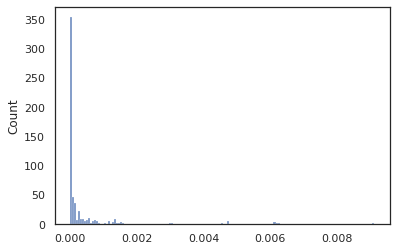

In [29]:
sns.histplot(percentage_uncertain)

In [8]:
input_file = rfmix_path + "chr{}.msp.tsv".format(chrom)
chr_df_msp = pd.read_csv(input_file, sep = "\t", header=1)
chr_df_msp

,#chm,spos,epos,sgpos,egpos,n snps,Sci_16066.0,Sci_16066.1,Sci_16098.0,Sci_16098.1,...,PD_0769.0,PD_0769.1,PD_0770.0,PD_0770.1,PD_0772.0,PD_0772.1,PD_0773.0,PD_0773.1,PD_0774.0,PD_0774.1
0,chrX,37,102016,0.00,0.73,4237,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1,chrX,102016,2125878,0.73,1.23,78605,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,chrX,2125878,3850659,1.23,2.16,76970,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,chrX,3850659,4207787,2.16,2.36,16200,1,1,3,1,...,3,3,3,1,1,1,1,1,3,1
4,chrX,4207787,5131342,2.36,2.79,35675,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,chrX,140836282,141477148,85.16,85.39,8740,3,1,1,1,...,1,1,1,1,1,1,1,1,1,1
348,chrX,141477148,141609609,85.39,85.48,4245,3,1,2,2,...,2,2,2,2,2,2,2,2,2,2
349,chrX,141609609,142188882,85.48,85.60,8205,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
350,chrX,142188882,142877354,85.60,85.78,8425,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
